In [1]:
%load_ext autoreload
%autoreload 2

# Basic Model

This notebook is for highlighting the initial data transformations, and running the data through a baseline model

In [2]:
import pandas as pd
import numpy as np
from data_prep import *

In [3]:
df = pd.read_csv('data/Foreign_Exchange_Rates.csv', index_col=0, na_values=['ND'])
df.head()

,Time Serie,AUSTRALIA - AUSTRALIAN DOLLAR/US$,EURO AREA - EURO/US$,NEW ZEALAND - NEW ZELAND DOLLAR/US$,UNITED KINGDOM - UNITED KINGDOM POUND/US$,BRAZIL - REAL/US$,CANADA - CANADIAN DOLLAR/US$,CHINA - YUAN/US$,HONG KONG - HONG KONG DOLLAR/US$,INDIA - INDIAN RUPEE/US$,...,SINGAPORE - SINGAPORE DOLLAR/US$,DENMARK - DANISH KRONE/US$,JAPAN - YEN/US$,MALAYSIA - RINGGIT/US$,NORWAY - NORWEGIAN KRONE/US$,SWEDEN - KRONA/US$,SRI LANKA - SRI LANKAN RUPEE/US$,SWITZERLAND - FRANC/US$,TAIWAN - NEW TAIWAN DOLLAR/US$,THAILAND - BAHT/US$
0,2000-01-03,1.5172,0.9847,1.9033,0.6146,1.8050,1.4465,8.2798,7.7765,43.55,...,1.6563,7.3290,101.70,3.8,7.964,8.4430,72.30,1.5808,31.38,36.97
1,2000-01-04,1.5239,0.9700,1.9238,0.6109,1.8405,1.4518,8.2799,7.7775,43.55,...,1.6535,7.2180,103.09,3.8,7.934,8.3600,72.65,1.5565,30.60,37.13
2,2000-01-05,1.5267,0.9676,1.9339,0.6092,1.8560,1.4518,8.2798,7.7780,43.55,...,1.6560,7.2080,103.77,3.8,7.935,8.3530,72.95,1.5526,30.80,37.10
3,2000-01-06,1.5291,0.9686,1.9436,0.6070,1.8400,1.4571,8.2797,7.7785,43.55,...,1.6655,7.2125,105.19,3.8,7.940,8.3675,72.95,1.5540,31.75,37.62
4,2000-01-07,1.5272,0.9714,1.9380,0.6104,1.8310,1.4505,8.2794,7.7783,43.55,...,1.6625,7.2285,105.17,3.8,7.966,8.4150,73.15,1.5623,30.85,37.30


In [4]:
df = fetch_data()
df.head()

,EURO
day,
2000-01-03,0.9847
2000-01-04,0.9700
2000-01-05,0.9676
2000-01-06,0.9686
2000-01-07,0.9714


In [5]:
work_df = scale_and_interpolate(df)
work_df.head()

,EURO
day,
2000-01-03,0.615977
2000-01-04,0.590831
2000-01-05,0.586726
2000-01-06,0.588437
2000-01-07,0.593226


In [6]:
set_target(work_df, 3)

,EURO,target
day,,
2000-01-03,0.615977,0.0
2000-01-04,0.590831,0.0
2000-01-05,0.586726,1.0
2000-01-06,0.588437,1.0
2000-01-07,0.593226,1.0
...,...,...
2019-12-25,0.473572,0.0
2019-12-26,0.472289,0.0
2019-12-27,0.462367,0.0


In [7]:
work_df = set_target(work_df, 2)

In [8]:

full_df = expand_columns(work_df, ['EURO'], 4)
full_df.head(n=10)


,EURO,target,EURO_1,EURO_2,EURO_3,EURO_4
day,,,,,,
2000-01-07,0.593226,1.0,0.588437,0.586726,0.590831,0.615977
2000-01-08,0.595507,1.0,0.593226,0.588437,0.586726,0.590831
2000-01-09,0.597788,1.0,0.595507,0.593226,0.588437,0.586726
2000-01-10,0.600068,0.0,0.597788,0.595507,0.593226,0.588437
2000-01-11,0.588779,1.0,0.600068,0.597788,0.595507,0.593226
2000-01-12,0.595450,1.0,0.588779,0.600068,0.597788,0.595507
2000-01-13,0.597160,1.0,0.595450,0.588779,0.600068,0.597788
2000-01-14,0.620595,1.0,0.597160,0.595450,0.588779,0.600068
2000-01-15,0.620852,1.0,0.620595,0.597160,0.595450,0.588779


In [9]:
import torch

In [10]:
x = torch.tensor(full_df.drop('target', axis=1).values).float()
target = torch.as_tensor(full_df['target'].values).long()
y = torch.nn.functional.one_hot(target, num_classes=2).float()
D_in = x.shape[1]
H = int(D_in/2)
D_out = 2

In [11]:
from torch.utils.data import DataLoader, Dataset

In [12]:
class BasicData(Dataset):
    def __init__(self, x, y):
        super().__init__()
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return x[idx], y[idx]


N = len(x)
train_cutoff = int(N*0.8)
training_data = BasicData(x[:train_cutoff], y[:train_cutoff])
test_data = BasicData(x[train_cutoff:], y[train_cutoff:])
train_loader = DataLoader(training_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

In [13]:
from model_utils import pred_accuracy, train_net

In [14]:
from plotting_utils import plot_train_test

In [15]:
class Net(torch.nn.Module):
    def __init__(self, inp_d, hid_d, out_d):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(inp_d, hid_d)
        self.fc2 = torch.nn.Linear(hid_d, out_d)

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return torch.sigmoid(x)


model = Net(5, 3, 2)

train_history, test_history = train_net(
    model, train_loader, test_data, epochs=200, learning_rate=0.01)

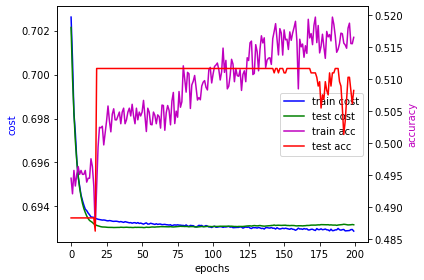

In [16]:
plot_train_test(train_history, test_history)

In [17]:
pred_accuracy(model(test_data.x), test_data.y)

tensor(0.5082)